# Evaluation of RAG vs Baseline
This notebook evaluates the question answering results stored in `results_baseline.csv` and `results_rag.csv`.
It visualises different metrics to compare the baseline system with the RAG implementation.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid')
palette = {'Baseline': 'tab:blue', 'RAG': 'tab:orange'}
heatmap_cmap = "Oranges"

baseline = pd.read_csv(Path('results_baseline.csv'))
rag = pd.read_csv(Path('results_rag.csv'))

ngram_metrics = ['precision-1','recall-1','ROUGE-1','precision-2','recall-2','ROUGE-2']
judge_metrics = ['factual_correctness','completeness','relevance','justification','depth']
metrics = ngram_metrics + judge_metrics

for df in (baseline, rag):
    for col in metrics + ['overall_score']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df['paper'] = df['question_id'].str.extract(r'^(..)_')
    df['n_score'] = df[ngram_metrics].mean(axis=1)
    df['judge_score'] = df[judge_metrics].mean(axis=1)


## Average metrics across all questions

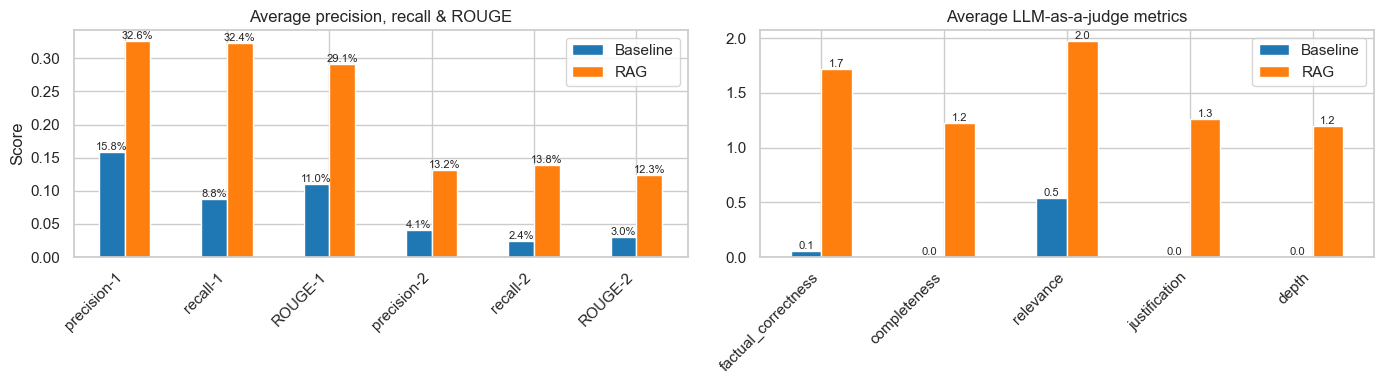

In [16]:
avg_base_n = baseline[ngram_metrics].mean()
avg_rag_n = rag[ngram_metrics].mean()
avg_base_j = baseline[judge_metrics].mean()
avg_rag_j = rag[judge_metrics].mean()
fig, axes = plt.subplots(1,2, figsize=(14,4))
pd.DataFrame({'Baseline': avg_base_n, 'RAG': avg_rag_n}).plot(kind='bar', ax=axes[0], color=[palette['Baseline'], palette['RAG']])
axes[0].set_ylabel('Score')
axes[0].set_title('Average precision, recall & ROUGE')
for p in axes[0].patches:
    height = p.get_height()
    label = f'{height:.1%}' if height <= 1 else f'{height:.1f}'
    axes[0].annotate(label, (p.get_x()+p.get_width()/2., height), 
                     ha='center', va='bottom', fontsize=8)
pd.DataFrame({'Baseline': avg_base_j, 'RAG': avg_rag_j}).plot(kind='bar', ax=axes[1], color=[palette['Baseline'], palette['RAG']])
axes[1].set_title('Average LLM-as-a-judge metrics')
for p in axes[1].patches:
    height = p.get_height()
    label = f'{height:.1f}' if height <= 1 else f'{height:.1f}'
    axes[1].annotate(label, (p.get_x()+p.get_width()/2., height), 
                     ha='center', va='bottom', fontsize=8)
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Pass/fail counts

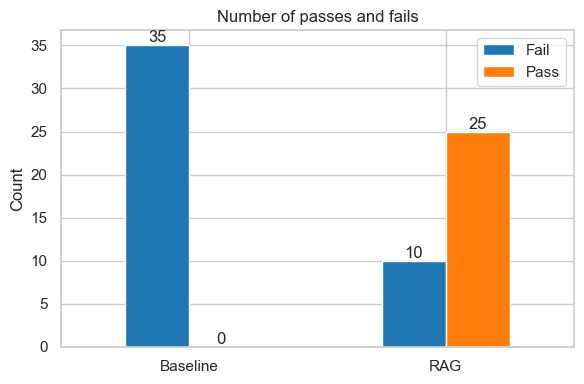

In [17]:
pass_base = baseline['pass'].astype(bool).value_counts()
pass_rag = rag['pass'].astype(bool).value_counts()
count_df = pd.DataFrame({'Baseline': pass_base, 'RAG': pass_rag}).fillna(0).T
count_df.columns = ['Fail','Pass']
ax = count_df.plot(kind='bar', stacked=False, figsize=(6,4), color=[palette['Baseline'], palette['RAG']])
ax.set_ylabel('Count')
ax.set_title('Number of passes and fails')
for c in ax.containers:
    ax.bar_label(c, label_type='edge')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Heatmaps of precision/recall/ROUGE per question

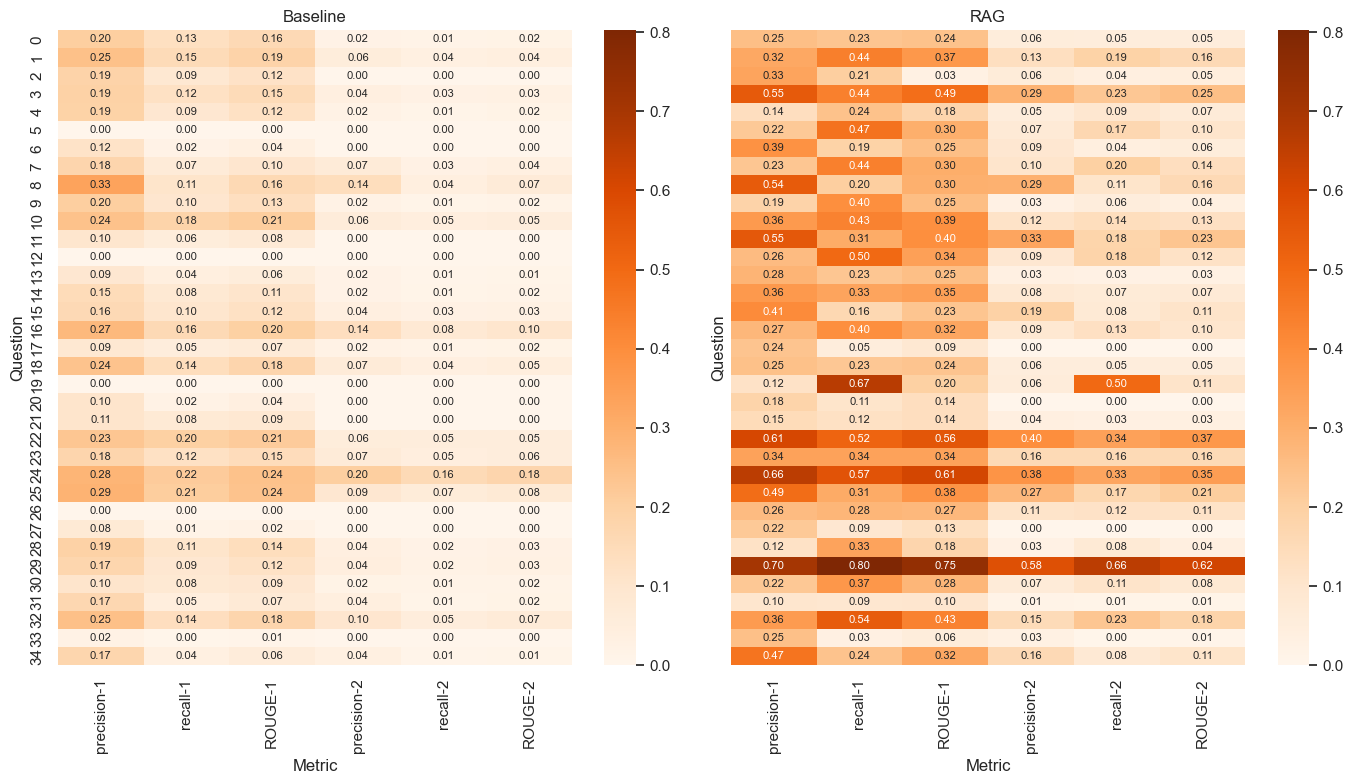

In [18]:
fig, axes = plt.subplots(1,2, figsize=(14,8), sharey=True)
vmin = min(baseline[ngram_metrics].min().min(), rag[ngram_metrics].min().min())
vmax = max(baseline[ngram_metrics].max().max(), rag[ngram_metrics].max().max())

sns.heatmap(
    baseline[ngram_metrics],
    ax=axes[0],
    vmin=vmin, vmax=vmax,
    cmap=heatmap_cmap,
    annot=True,         # turn on annotation
    fmt='.2f',          # two decimals
    annot_kws={'fontsize':8}  # optional styling
)
axes[0].set_title('Baseline')

sns.heatmap(
    rag[ngram_metrics],
    ax=axes[1],
    vmin=vmin, vmax=vmax,
    cmap=heatmap_cmap,
    annot=True,
    fmt='.2f',
    annot_kws={'fontsize':8}
)
axes[1].set_title('RAG')

for ax in axes:
    ax.set_xlabel('Metric')
    ax.set_ylabel('Question')

plt.tight_layout()
plt.show()


## Metrics per paper

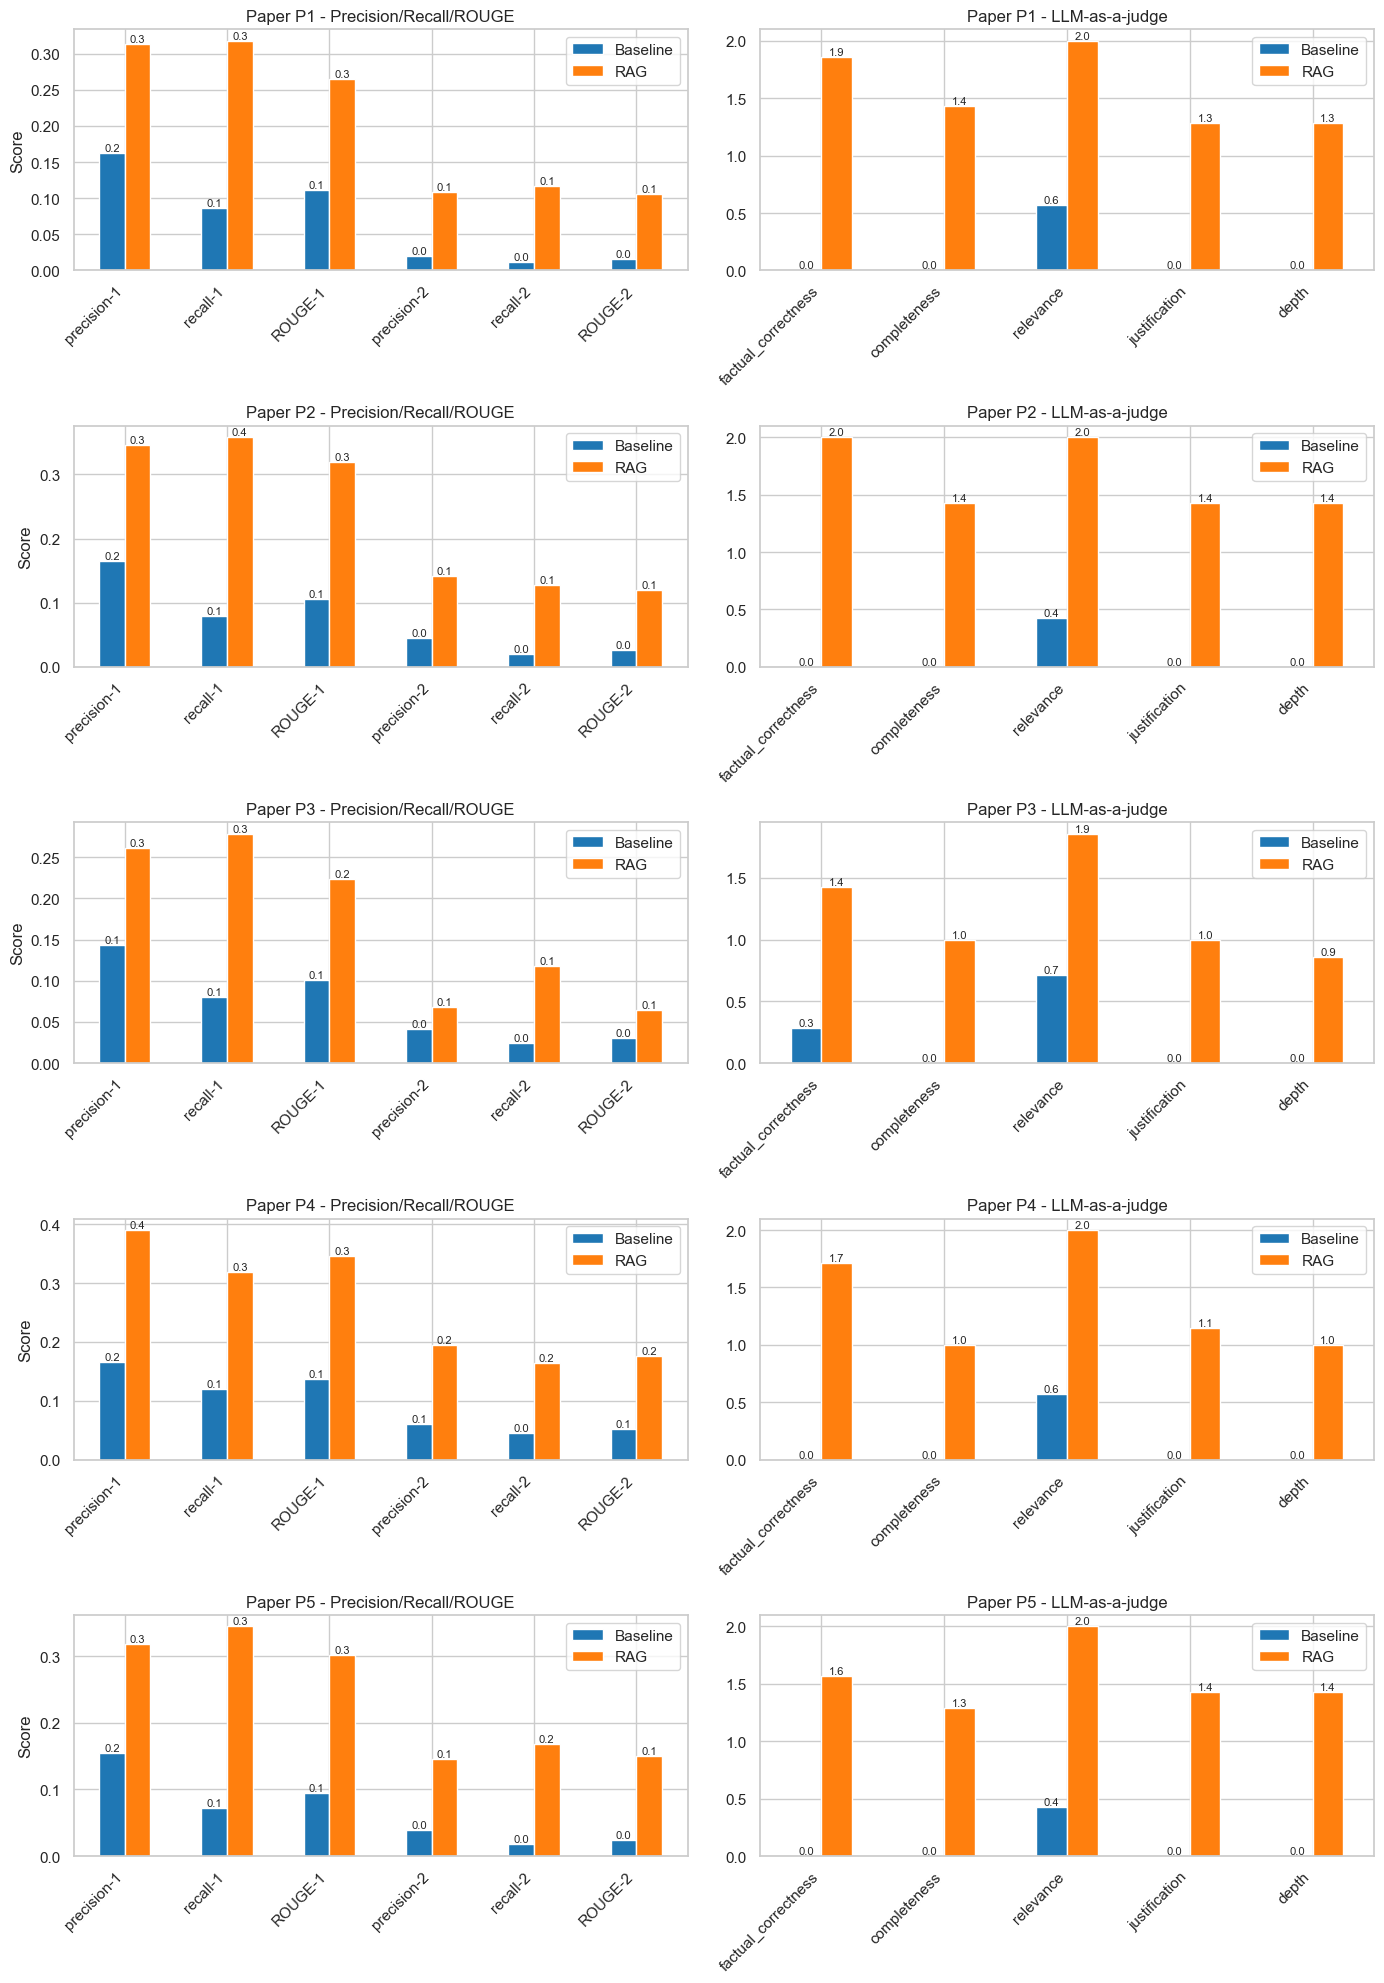

In [19]:
papers = sorted(baseline['paper'].unique())
fig, axes = plt.subplots(len(papers), 2, figsize=(14, 4*len(papers)))
for idx, paper in enumerate(papers):
    b_group = baseline[baseline['paper']==paper]
    r_group = rag[rag['paper']==paper]
    avg_b_n = b_group[ngram_metrics].mean()
    avg_r_n = r_group[ngram_metrics].mean()
    avg_b_j = b_group[judge_metrics].mean()
    avg_r_j = r_group[judge_metrics].mean()
    pd.DataFrame({'Baseline': avg_b_n, 'RAG': avg_r_n}).plot(kind='bar', ax=axes[idx,0], color=[palette['Baseline'], palette['RAG']])
    axes[idx,0].set_ylabel('Score')
    axes[idx,0].set_title(f'Paper {paper} - Precision/Recall/ROUGE')
    pd.DataFrame({'Baseline': avg_b_j, 'RAG': avg_r_j}).plot(kind='bar', ax=axes[idx,1], color=[palette['Baseline'], palette['RAG']])
    axes[idx,1].set_title(f'Paper {paper} - LLM-as-a-judge')
    for ax in axes[idx]:
        for p in ax.patches:
            height = p.get_height()
            label = f'{height:.1f}' if height <= 1 else f'{height:.1f}'
            ax.annotate(label, (p.get_x()+p.get_width()/2., height), ha='center', va='bottom', fontsize=8)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Correlation between LLM-as-judge metrics and n-gram metrics

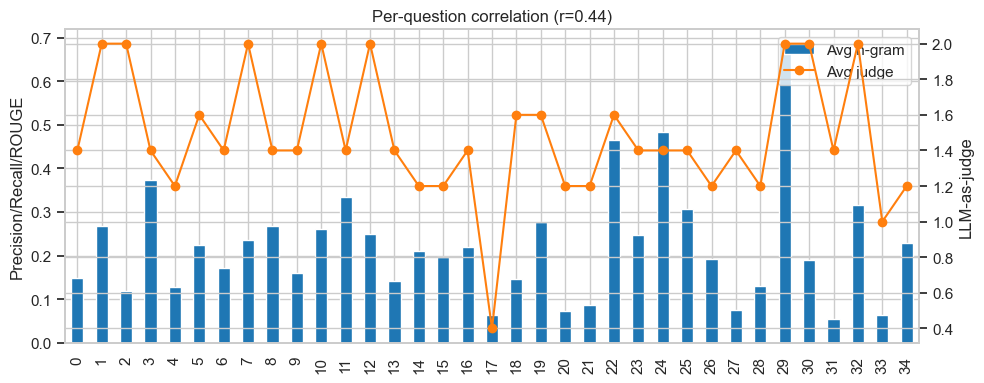

In [20]:
corr_val = rag['n_score'].corr(rag['judge_score'])
fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()
rag['n_score'].plot(kind='bar', ax=ax1, color=palette['Baseline'], label='Avg n-gram')
rag['judge_score'].plot(kind='line', ax=ax2, color=palette['RAG'], marker='o', label='Avg judge')
ax1.set_ylabel('Precision/Recall/ROUGE')
ax2.set_ylabel('LLM-as-judge')
ax1.set_title(f'Per-question correlation (r={corr_val:.2f})')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc='upper right')
plt.tight_layout()
plt.show()


## Additional plots

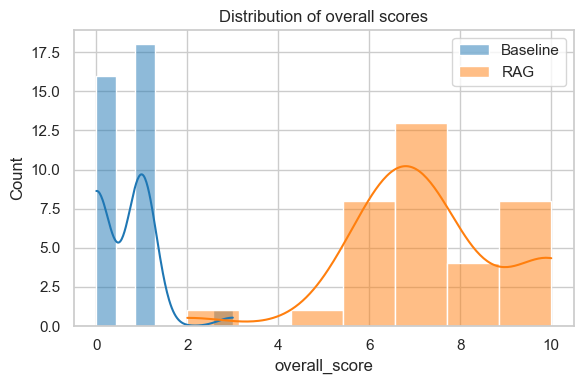

In [21]:
# Distribution of overall scores
plt.figure(figsize=(6,4))
sns.histplot(baseline['overall_score'], color=palette['Baseline'], label='Baseline', kde=True)
sns.histplot(rag['overall_score'], color=palette['RAG'], label='RAG', kde=True)
plt.legend()
plt.title('Distribution of overall scores')
plt.tight_layout()
plt.show()


### More visualisations

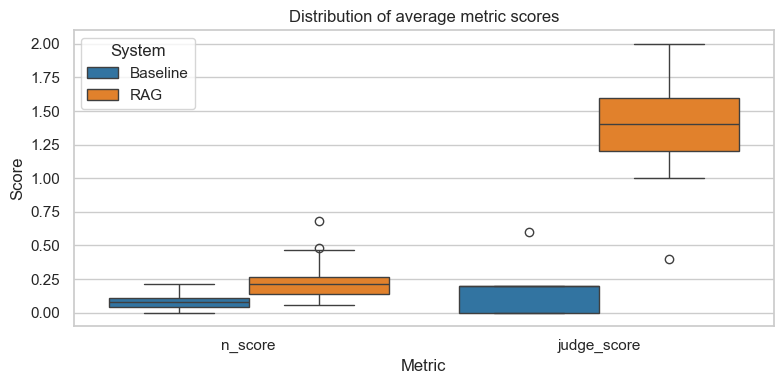

In [22]:
# Boxplot of average scores
scores = pd.concat([
    baseline[['n_score','judge_score']].assign(System='Baseline'),
    rag[['n_score','judge_score']].assign(System='RAG')
]).melt(id_vars='System', var_name='Metric', value_name='Score')
plt.figure(figsize=(8,4))
sns.boxplot(data=scores, x='Metric', y='Score', hue='System', palette=[palette['Baseline'], palette['RAG']])
plt.title('Distribution of average metric scores')
plt.tight_layout()
plt.show()


In [23]:
# 1) make the column
combined['total_score'] = combined['n_score'] + combined['judge_score']

# 2) pick a dummy x (like the question number), or use overall_score
sns.lmplot(
    data=combined,
    x='total_score',      # your new “x”
    y='overall_score',    # or reuse judge_score / another metric
    hue='System',
    palette=palette,
    aspect=1.5
)
plt.title("Total score vs. overall_score by System")
plt.tight_layout()
plt.show()


NameError: name 'combined' is not defined